# 타이타닉 데이터 로드 후 정보 확인
## 아래의 코드는 점검을 위한 코드이며, 데이터 전처리 및 그 외 코드들은 최선의 코드가 아님

## 데이터 로드

In [7]:
import pandas as pd
import numpy as np

df = pd.read_csv("titanic.csv")

* Passengerid: 탑승자 데이터 일련번호
* survived: 생존 여부, 0 = 사망, 1 = 생존
* Pclass: 티켓의 선실 등급, 1 = 일등석, 2 = 이등석, 3 = 삼등석
* sex: 탑승자 성별
* name: 탑승자 이름
* Age: 탑승자 나이
* sibsp: 같이 탑승한 형제자매 또는 배우자 인원수
* parch: 같이 탑승한 부모님 또는 어린이 인원수
* ticket: 티켓 번호
* fare: 요금
* cabin: 선실 번호
* embarked: 중간 정착 항구 C = Cherbourg, Q = Queenstown, S = Southampton

# 데이터 전처리

## 결측지 처리
- Age >>>> 평균 값으로 채우기
- Carbin >>>> N으로 채우기
- Embarked >>>> N으로 채우기

In [1]:
def fillna(df):
    df['Age']=df['Age'].fillna(df['Age'].mean())
    df['Cabin']=df['Cabin'].fillna('N')
    df['Embarked']=df['Embarked'].fillna('N')
    return df

## 필요 없는 컬럼 제거
- PassengerId
- Name
- Ticket

In [2]:
def drop_features(df):
    return df.drop(['PassengerId','Name','Ticket'],axis=1)

## 범주형 데이터 처리
- Sex >>>> 숫자형 변환
- Embarked >>>> 숫자형 변환
- Cabin >>>> 첫 번째 문자만 추출 후 숫자형 변환

In [9]:
from sklearn.preprocessing import LabelEncoder
def format_features(df):
    df['Cabin']=df['Cabin'].astype(str).str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        df[feature]=le.fit_transform(df[feature])
    return df    

#데이터 전처리 함수
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

## 데이터 분리(X, y)

In [10]:
y_titanic_df = df['Survived']
X_titanic_df = df.drop('Survived',axis=1,inplace=False)
X_titanic_df = transform_features(X_titanic_df)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_titanic_df,y_titanic_df,test_size=0.2,random_state=11)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

X_titanic_df
X_titanic_df.isnull().sum()

(712, 8) (179, 8) (712,) (179,)


Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    0
dtype: int64

## 모델 학습
- DecisionTreeClassifier
- RandomForestClassifier
- LogisticRegression

DecisionTree 정확도: 0.8045
Confusion Matrix:
 [[101  17]
 [ 18  43]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.85       118
           1       0.72      0.70      0.71        61

    accuracy                           0.80       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.80      0.80      0.80       179

RandomForest 정확도: 0.8436
Confusion Matrix:
 [[106  12]
 [ 16  45]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.88       118
           1       0.79      0.74      0.76        61

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.84      0.84      0.84       179

LogisticRegression 정확도: 0.8659
Confusion Matrix:
 [[108  10]
 [ 14  47]]
Classification_Report:
               precision    recall  f1-score   support

           0

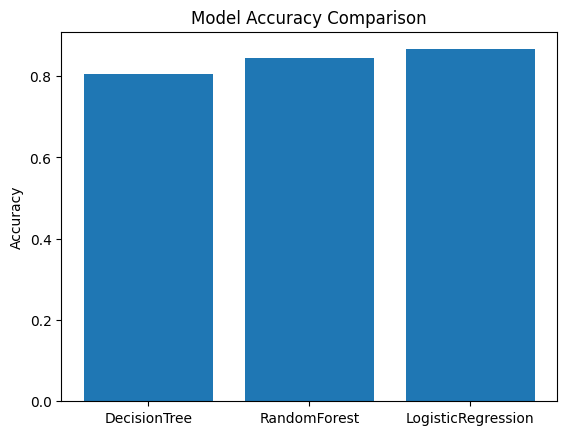

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

# 모델 정의
models = {
    'DecisionTree': DecisionTreeClassifier(random_state=44),
    'RandomForest': RandomForestClassifier(random_state=44),
    'LogisticRegression': LogisticRegression(solver='liblinear') 
}

# 평가
def evaluate_models(models,X_train,X_test,y_train,y_test):
    results={}
    for name,model in models.items():
        model.fit(X_train,y_train)
        pred = model.predict(X_test)
        acc = accuracy_score(y_test,pred)
        results[name]= acc
        print(f'{name} 정확도: {acc:.4f}')
        print("Confusion Matrix:\n",confusion_matrix(y_test,pred))
        print("Classification_Report:\n",classification_report(y_test,pred))
    return results


# 모델 평가
results = evaluate_models(models, X_train, X_test, y_train, y_test)

# 시각화
import matplotlib.pyplot as plt

plt.bar(results.keys(), results.values())
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()


## 모델 학습
- K-Fold 교차 검증

In [17]:
# for 문
from sklearn.model_selection import KFold

def exec_kfold(clf,folds=5):
    kfold = KFold(n_splits=folds)
    scores=[]
    for iter_count,(train_index,test_index) in enumerate(kfold.split(X_titanic_df)):
        X_train,X_test = X_titanic_df.values[train_index],X_titanic_df.values[test_index]
        y_train,y_test = y_titanic_df.values[train_index],y_titanic_df.values[test_index]
        clf.fit(X_train,y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test,predictions)
        scores.append(accuracy)
        print(f'교차 검증 {iter_count} 정확도: {accuracy:.4f}')
    mean_score = np.mean(scores)
    print(f'평균 정확도:{mean_score:.4f}')

exec_kfold(DecisionTreeClassifier(random_state=11))





교차 검증 0 정확도: 0.7542
교차 검증 1 정확도: 0.7809
교차 검증 2 정확도: 0.7865
교차 검증 3 정확도: 0.7697
교차 검증 4 정확도: 0.8202
평균 정확도:0.7823


## cross_val_score

In [18]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(DecisionTreeClassifier(random_state=44),X_titanic_df,y_titanic_df,cv=5)

for iter_count, accuracy in enumerate(scores):
    print(f'교차 검증: {iter_count},정확도: {accuracy}')
print(f'평균정확도>>>>>{np.mean(scores):.4f}')

교차 검증: 0,정확도: 0.7653631284916201
교차 검증: 1,정확도: 0.7752808988764045
교차 검증: 2,정확도: 0.797752808988764
교차 검증: 3,정확도: 0.7808988764044944
교차 검증: 4,정확도: 0.8258426966292135
평균정확도>>>>>0.7890


## 하이퍼파라미터 튜닝(알려 드릴 예정)

In [19]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2,3,5,10],
              'min_samples_split':[2,3,5],
              'min_samples_leaf':[1,5,8]}
grid_dclf=GridSearchCV(DecisionTreeClassifier(random_state=44),param_grid=parameters,scoring='accuracy',cv=5)
grid_dclf.fit(X_train,y_train)

print(f'GridSearchCV 최적 하이퍼 파라미터 >>>> {grid_dclf.best_params_}')
print(f'GridSearchCV 최고 정확도: {grid_dclf.best_score_}')

GridSearchCV 최적 하이퍼 파라미터 >>>> {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.7991825076332119


1. 조합 정의
2. 교차 검증
3. 최적이 조합 선택
4. 최적의 모델 반환

In [20]:
# 라이브러리 가져오기
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# depth >>>> 너무 깊으면 과적합 될 가능성 높음
# split >>>> 작으면 작을수록 트리 복잡
# leaf >>>> 리프 노드가 최소한의 데이터를 포함하도록 설정
parameters = {'max_depth': [2, 3, 5, 10],
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 5, 8]}

# 조합의 개수
# 조합수 = 4 x 3 x 3 == 36

In [21]:
grid_dclf = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=44),
    param_grid=parameters,
    scoring='accuracy',
    cv=5
)
grid_dclf.fit(X_titanic_df, y_titanic_df)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=44),
             param_grid={'max_depth': [2, 3, 5, 10],
                         'min_samples_leaf': [1, 5, 8],
                         'min_samples_split': [2, 3, 5]},
             scoring='accuracy')

## Pipeline 활용(알려 드릴 예정)